This is used in the paper **Flexible cable routing framework for wind farm collection system optimization**.

In [1]:
from importlib.resources import files
import dill
from pyomo import environ as pyo

In [2]:
from interarray.interarraylib import G_from_S
from interarray.svg import svgplot
from interarray.mesh import make_planar_embedding
from interarray.baselines.hgs import hgs_multiroot
from interarray.importer import L_from_yaml
from interarray.pathfinding import PathFinder
import interarray.MILP.pyomo as omo

In [3]:
solver = pyo.SolverFactory('gurobi', solver_io='python')

## Reference solution

Yi, X., Scutariu, M., & Smith, K. (2019). Optimisation of offshore wind farm inter-array collection system. IET Renewable Power Generation, 13(11), 1990–1999. https://doi.org/10.1049/iet-rpg.2018.5805

The network was not parsed from the paper, using the published total cable lengths:
- radial: 162.3 km
- branched: 154.6 km

In [4]:
λ_radial = 162300
λ_branched = 154600

## Start here

In [5]:
base_dir = files('interarray.data')
inputfile = base_dir / 'Yi-2019.yaml'
L = L_from_yaml(inputfile)

In [6]:
P, A = make_planar_embedding(L)

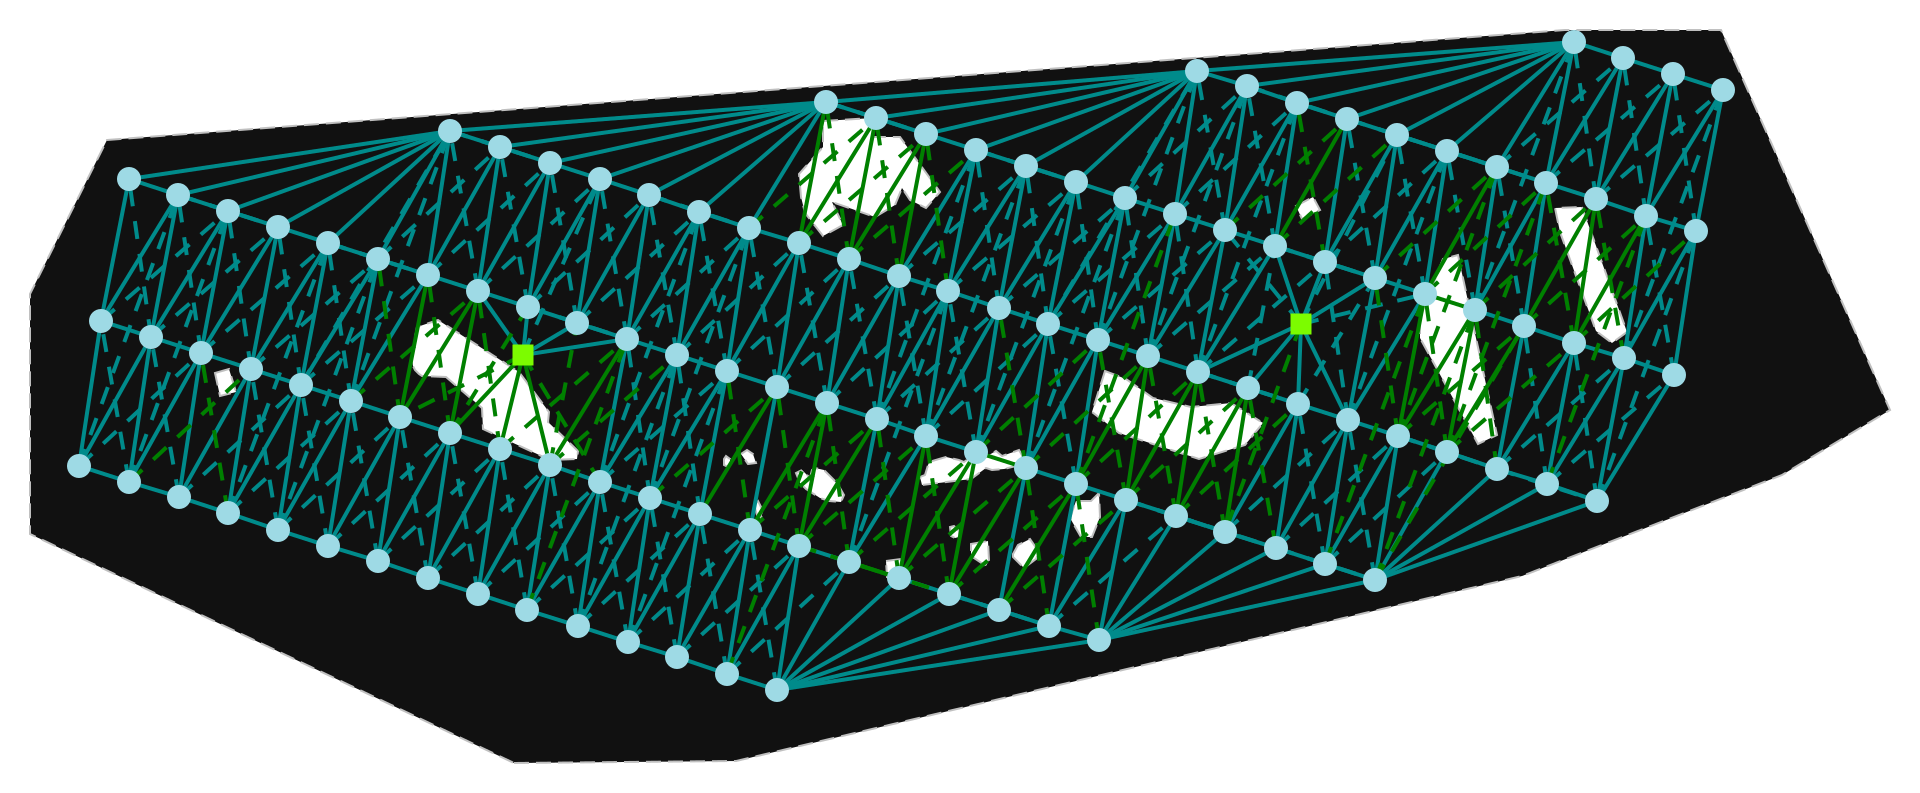

In [7]:
svgplot(A)

## Solve κ = 6 (branched)

In [8]:
Sʹ = hgs_multiroot(A, capacity=6, time_limit=0.5)

In [9]:
Sʹ.graph['solution_time']

(0.04, 0.22)

In [10]:
Gʹ = G_from_S(Sʹ, A)

In [11]:
Hʹ = PathFinder(Gʹ, planar=P, A=A).create_detours()

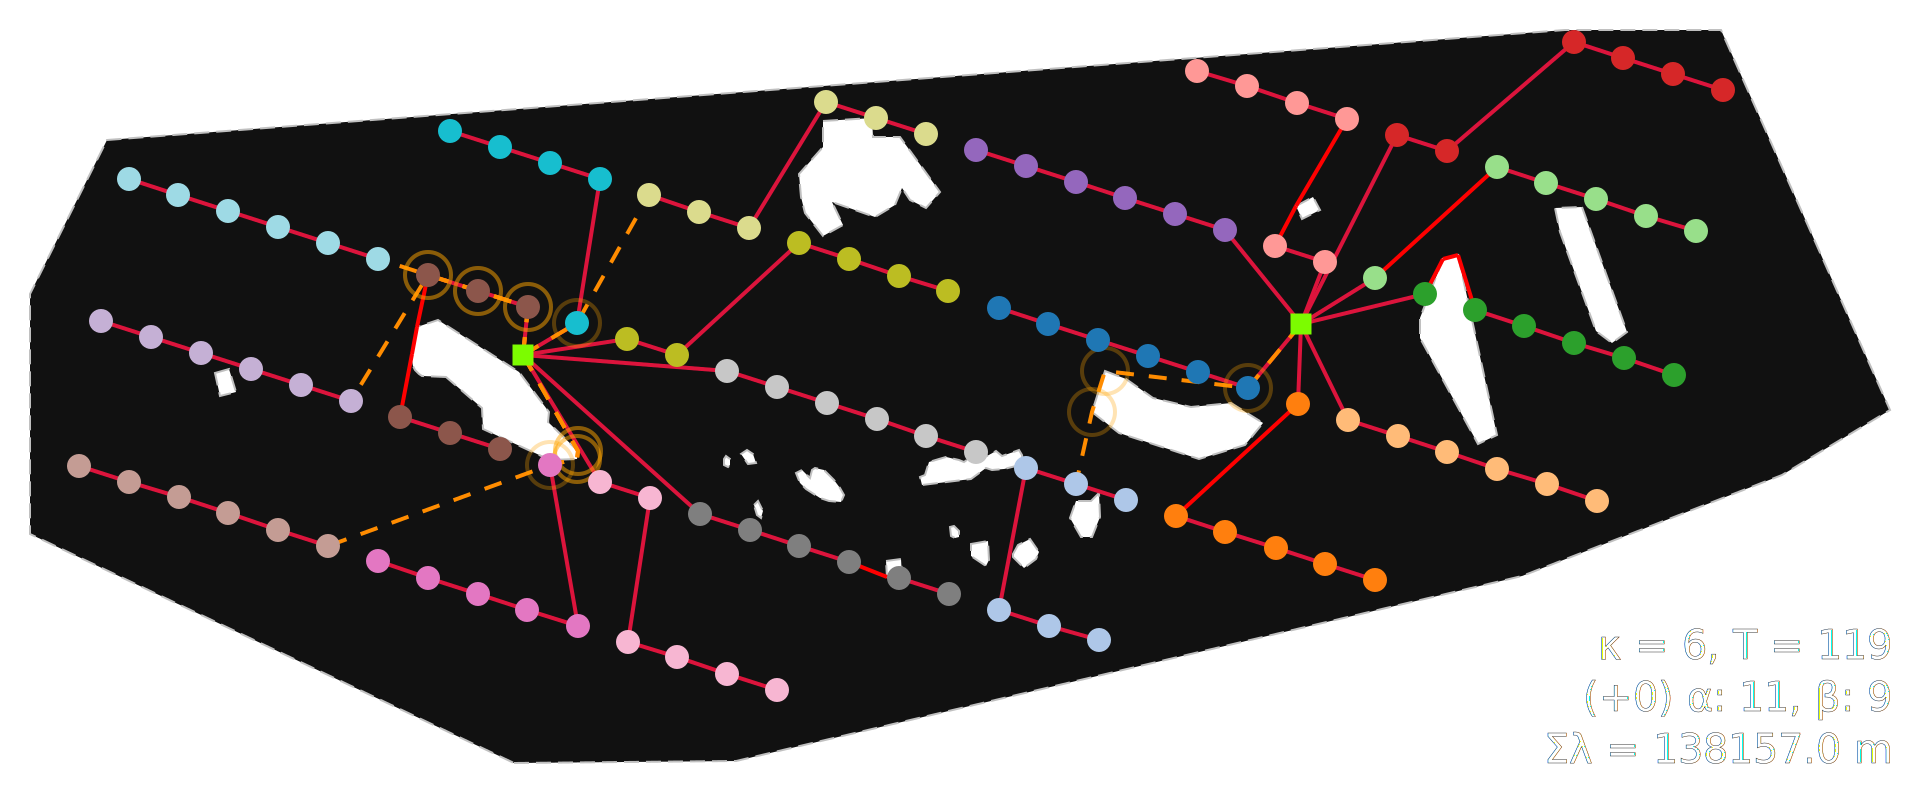

In [12]:
svgplot(Hʹ)

In [13]:
1 - Hʹ.size(weight='length')/λ_branched

0.10635713818204917

In [14]:
capacity = 6
# build model and pre-load solution from Sʹ
model = omo.make_min_length_model(
    A, capacity,
    gateXings_constraint=False,
    gates_limit=True,
    branching=True
)
# omo.warmup_model(model, Sʹ)  # warm-start hinders Gurobi in this instance

In [15]:
solver.options.mipgap = 0.005  # 0.5 %
solver.options.timelimit = 45  # [s]
solver.options.mipfocus = 1  # focus on producing solutions
print(f'Solving "{model.handle}": {{R={len(model.R)}, T={len(model.T)}, k={model.k.value}}}\n')
status = solver.solve(model, warmstart=model.warmed_by, tee=True)

Solving "None": {R=2, T=119, k=6}

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.005
Set parameter TimeLimit to value 45
Set parameter MIPFocus to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  45
MIPGap  0.005
MIPFocus  1

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 3971 rows, 2592 columns and 14780 nonzeros
Model fingerprint: 0x730fe10f
Variable types: 0 continuous, 2592 integer (1296 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [7e+02, 2e+04]
  Bounds range     [1e+00, 6e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 534 rows and 0 columns
Presolve time: 0.04s
Presolved: 3437 rows, 2592 columns, 12182 

In [16]:
H = omo.gurobi_investigate_pool(P, A, model, solver, status)

Solution pool has 10 solutions.
Incumbent has (detoured) length: 133885.478
Pool investigation over - next best undetoured length: 134188.670


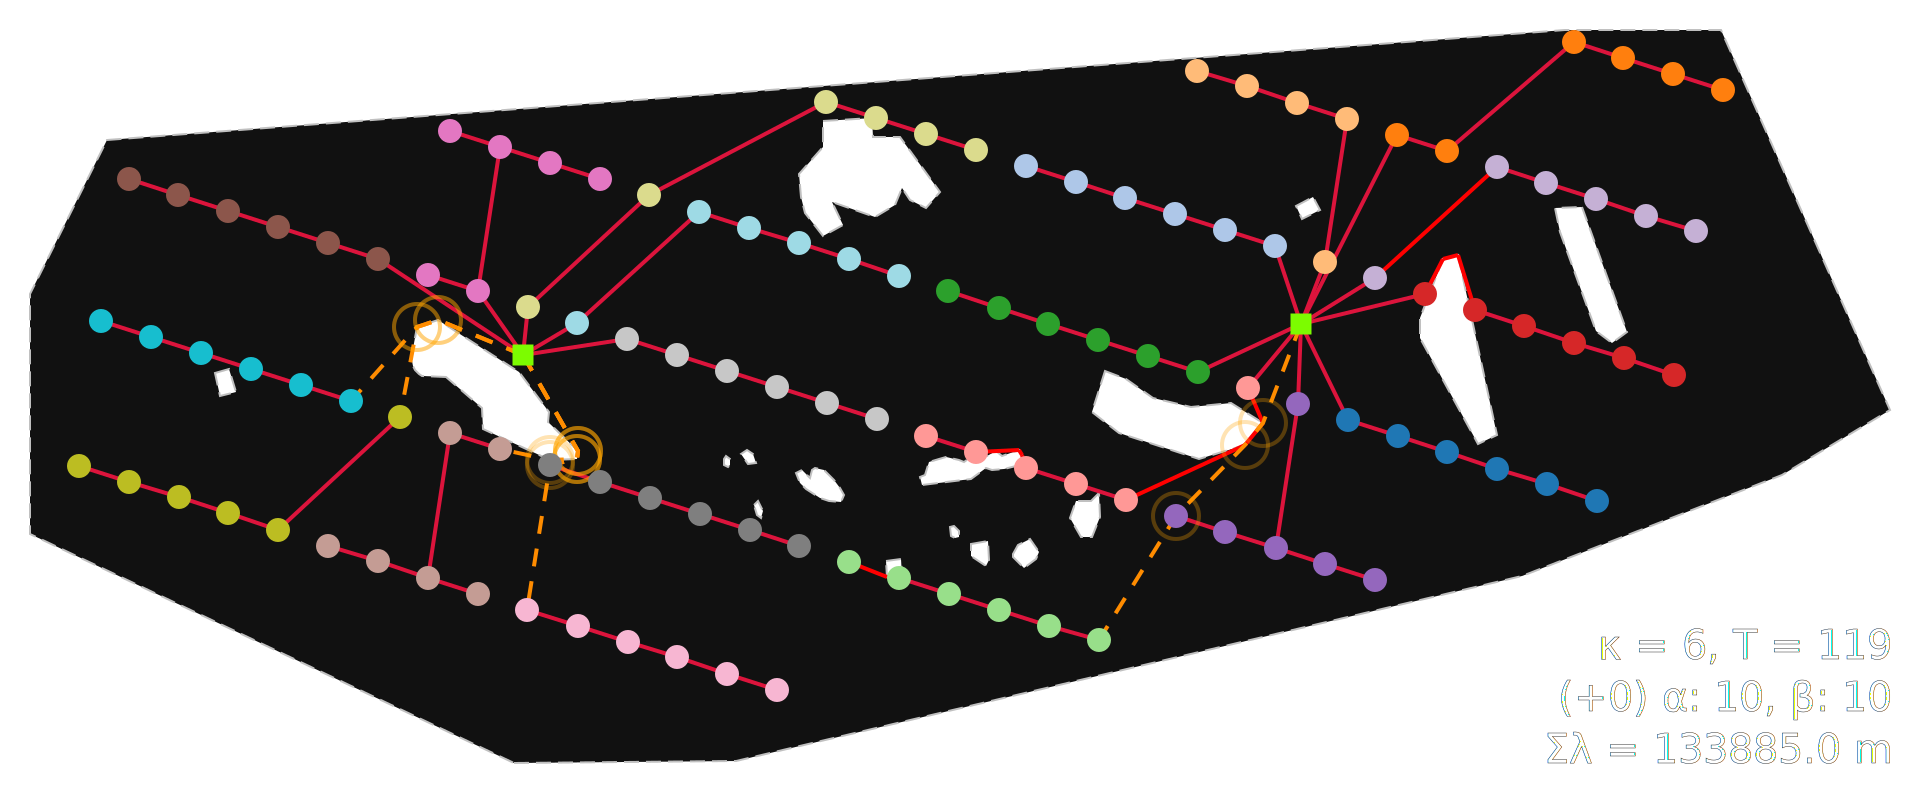

In [17]:
svgplot(H)

In [18]:
1 - H.size(weight='length')/λ_branched

0.13398784961608867

In [19]:
with open('yi_2019_κ_6_branched_ours.dill', 'wb') as outfile:
    dill.dump(H, outfile)

## Solve κ = 6 (radial)

In [20]:
Sʹ = hgs_multiroot(A, capacity=6, time_limit=0.5)

In [21]:
Sʹ.graph['solution_time']

(0.04, 0.25)

In [22]:
Gʹ = G_from_S(Sʹ, A)

In [23]:
Hʹ = PathFinder(Gʹ, planar=P, A=A).create_detours()

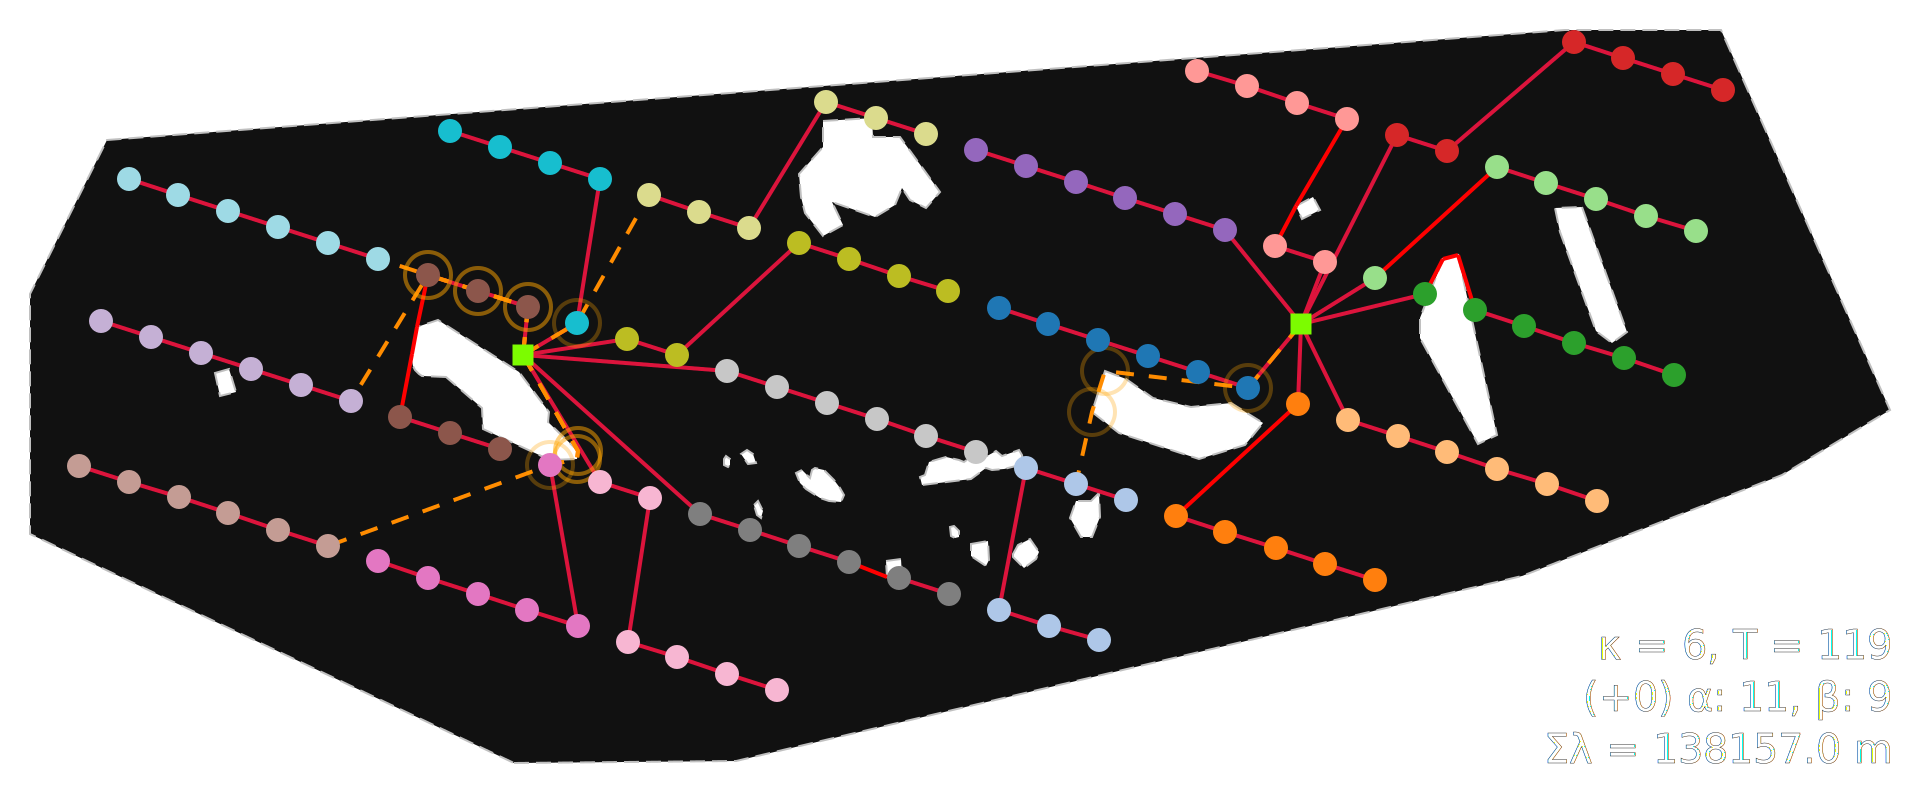

In [24]:
svgplot(Hʹ)

In [25]:
1 - Hʹ.size(weight='length')/λ_radial

0.1487542425320073

In [26]:
capacity = 6
# build model and pre-load solution from Sʹ
model = omo.make_min_length_model(
    A, capacity,
    gateXings_constraint=False,
    gates_limit=True,
    branching=False
)
omo.warmup_model(model, Sʹ)

In [27]:
solver.options.mipgap = 0.005  # 0.5 %
solver.options.timelimit = 45  # [s]
solver.options.mipfocus = 1  # focus on producing solutions
print(f'Solving "{model.handle}": {{R={len(model.R)}, T={len(model.T)}, k={model.k.value}}}\n')
status = solver.solve(model, warmstart=model.warmed_by, tee=True)

Solving "None": {R=2, T=119, k=6}

Set parameter OutputFlag to value 1
Set parameter MIPGap to value 0.005
Set parameter TimeLimit to value 45
Set parameter MIPFocus to value 1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Non-default parameters:
TimeLimit  45
MIPGap  0.005
MIPFocus  1

Academic license 937681 - for non-commercial use only - registered to ma___@dtu.dk
Optimize a model with 4090 rows, 2592 columns and 15838 nonzeros
Model fingerprint: 0xc57a99b1
Variable types: 0 continuous, 2592 integer (1296 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [7e+02, 2e+04]
  Bounds range     [1e+00, 6e+00]
  RHS range        [1e+00, 1e+02]

Loaded user MIP start with objective 134833

Presolve removed 534 rows and 0 columns
Presolve time: 0.

In [28]:
H = omo.gurobi_investigate_pool(P, A, model, solver, status)

Solution pool has 10 solutions.
Incumbent has (detoured) length: 134591.858
Incumbent has (detoured) length: 134519.759
Pool investigation over - next best undetoured length: 134565.292


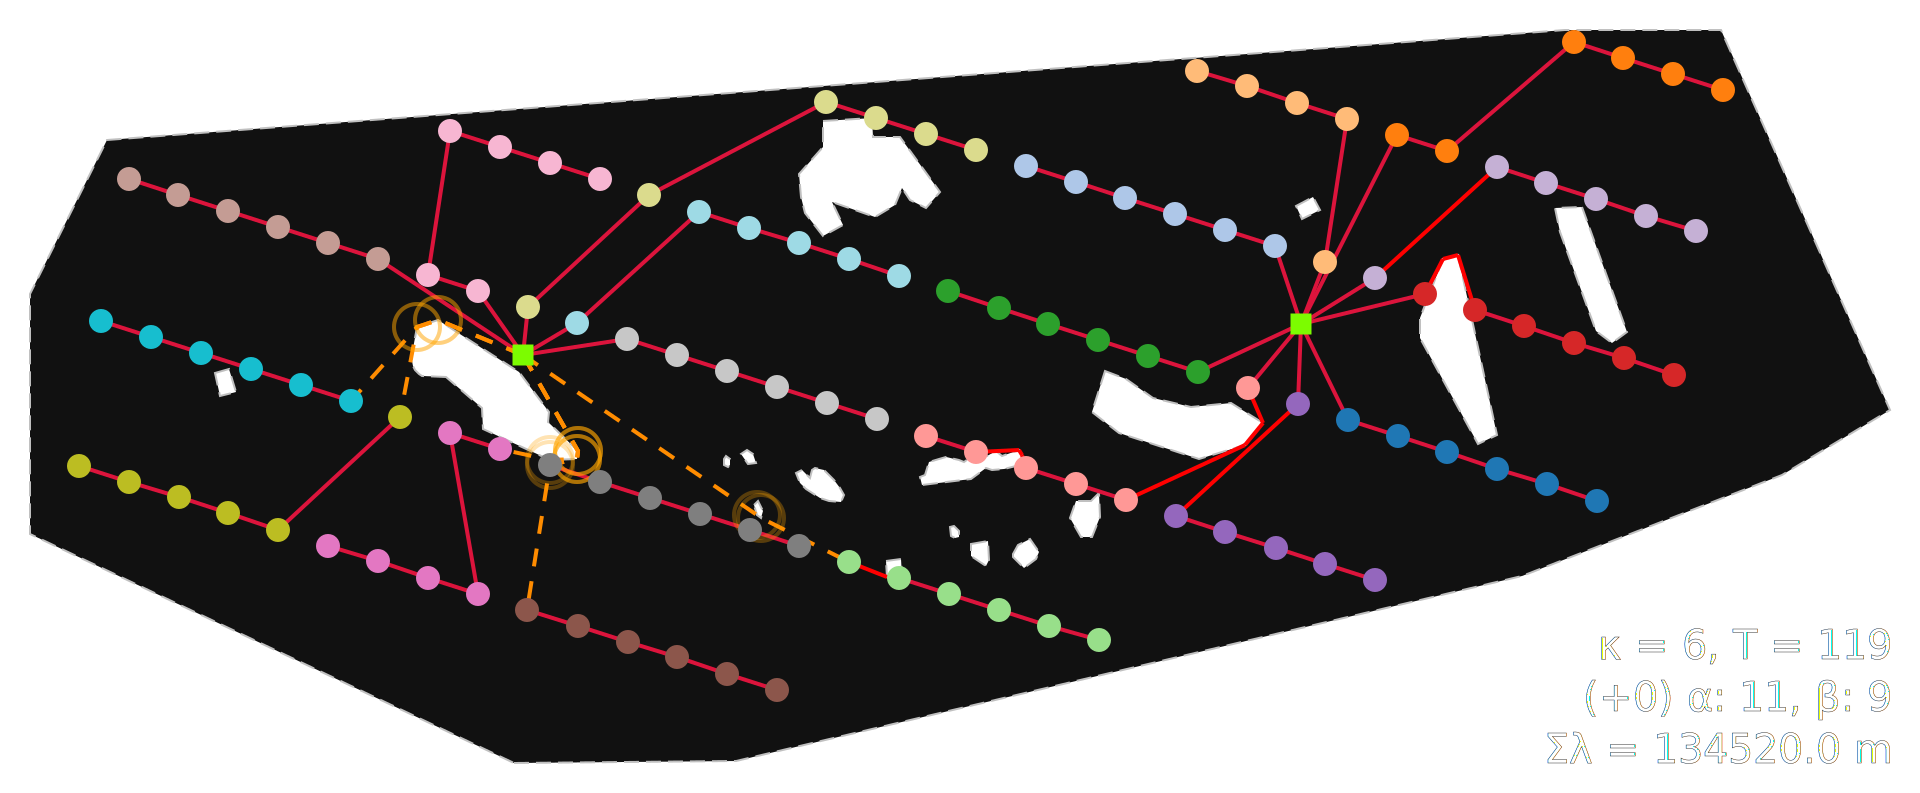

In [29]:
svgplot(H)

In [30]:
1 - H.size(weight='length')/λ_radial

0.17116599470734628

In [31]:
with open('yi_2019_κ_6_radial_ours.dill', 'wb') as outfile:
    dill.dump(H, outfile)